In [2]:
%run ../notebook_preamble.ipy

import seaborn as sns
import pymc3 as pm
import scipy.stats as ss
import theano.tensor as tt
from snepits.models.models_spec import *
from snepits.models.pymc_wrapper import PymcWrapper, PymcWrapperGrad

from pymc3.step_methods import SMC

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


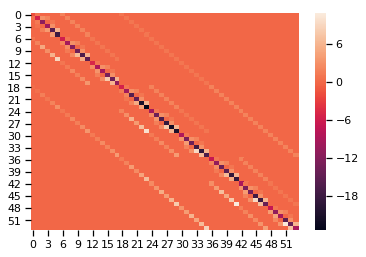

In [77]:
from snepits.pyovpyx import *

A, R = 3, 2
beta = np.array([
    [0, 1, 2],
    [0, 2, 3],
    [0, 1, 4],
], dtype=np.double).T
gamma = np.array([
    [0, 1, 2],
    [0, 2, 1],
    [0, 1, 3],
], dtype=np.double).T
rho = np.array([
    [1, 2, 0],
    [3, 1, 0],
    [1, 2, 0],
], dtype=np.double).T
eps = 0.3
alpha = 1
cf = 10

Ntup = np.array([1, 1, 2], dtype=np.int)

M = SIS_AR_gen(A, R, Ntup, beta, gamma, rho, eps, alpha, cf)

sns.set_context("notebook")
fig, ax = plt.subplots()  # figsize=(12, 12))
annot = True if M.shape[0] < 30 else False
sns.heatmap(M.todense(), annot=False, ax=ax)

# SIS

In [14]:
m = SIS_pop
sizes = np.ones(100, dtype=np.int) * 4
params = np.array([1, 0.25, 0.8])

model = m(sizes=sizes, params=params, data=None)

2020-02-13 17:25:38,307 - root - INFO - seed: 150837
2020-02-13 17:25:38,308 - root - INFO - seed: True


(array([25., 24., 29., 16.,  6.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]),
 <a list of 5 Patch objects>)

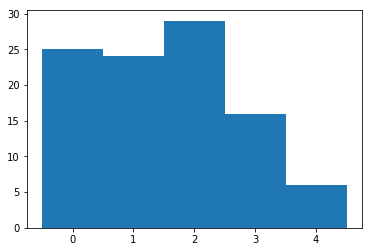

In [15]:
plt.hist(model.infected, bins=np.arange(-0.5, 5))

2020-02-13 17:25:41,745 - pymc3 - INFO - Auto-assigning NUTS sampler...
2020-02-13 17:25:41,747 - pymc3 - INFO - Initializing NUTS using jitter+adapt_diag...
2020-02-13 17:25:43,302 - pymc3 - INFO - Multiprocess sampling (4 chains in 4 jobs)
2020-02-13 17:25:43,303 - pymc3 - INFO - NUTS: [e, c, m]


Sampling 4 chains: 100%|██████████| 6000/6000 [00:25<00:00, 237.92draws/s]


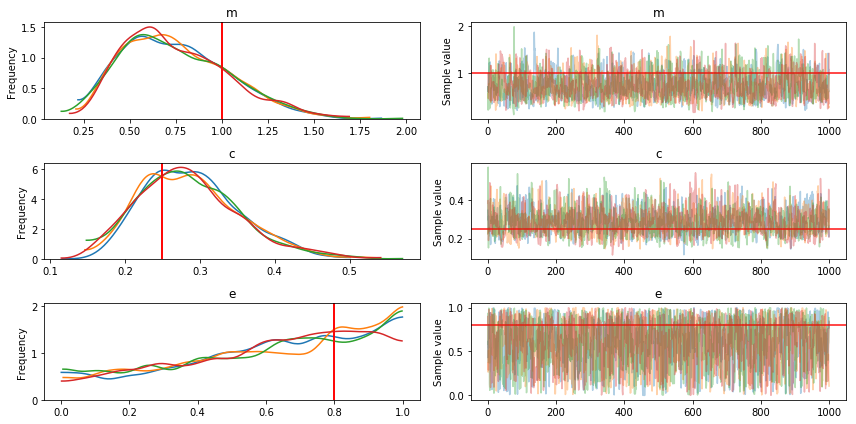

In [16]:
loglike = PymcWrapper(model)

ndraws = 500 * 2
nburn = 500

with pm.Model() as pm_model:
    beta = pm.HalfNormal('beta', sd=5)
    eps = pm.Uniform('eps', lower=0., upper=10.)
    alpha = pm.Uniform('alpha', lower=0., upper=1.)

    theta = tt.as_tensor_variable([m, c, e])
    pm.Potential('likelihood', loglike(theta))

    trace = pm.sample(ndraws, tune=nburn, discard_tuned_samples=True)

_ = pm.traceplot(trace, lines={'beta': model.t_params[0], 'eps': model.t_params[1], 'alpha': model.t_params[2]})

# SIS ACR - MODEL DOESN'T EXIST

In [79]:
m = SIS_ACR_pop_gen
params = np.array([1, 1, 2, 1.5, 1, 1, 0.1])
sizes = np.ones((100, 2), dtype=np.int) * 4

model = m(SIS_ACR_orthogonal_reparam, sizes=sizes, params=params, data=None)

2020-02-13 11:29:53,544 - root - INFO - seed: 363947
2020-02-13 11:29:53,545 - root - INFO - seed: True


Sample initial stage: ...


2020-02-13 15:04:43,283 - pymc3 - INFO - Sample initial stage: ...


Stage: 0 Beta: 0.007446 Steps: 25


2020-02-13 15:04:48,591 - pymc3 - INFO - Stage: 0 Beta: 0.007446 Steps: 25


100%|██████████| 1000/1000 [01:14<00:00, 13.41it/s]
Stage: 1 Beta: 0.031526 Steps: 25


2020-02-13 15:06:05,608 - pymc3 - INFO - Stage: 1 Beta: 0.031526 Steps: 25


100%|██████████| 1000/1000 [00:55<00:00, 17.97it/s]
Stage: 2 Beta: 0.083670 Steps: 2


2020-02-13 15:07:03,724 - pymc3 - INFO - Stage: 2 Beta: 0.083670 Steps: 2


100%|██████████| 1000/1000 [00:05<00:00, 183.40it/s]
Stage: 3 Beta: 0.180048 Steps: 25


2020-02-13 15:07:11,663 - pymc3 - INFO - Stage: 3 Beta: 0.180048 Steps: 25


100%|██████████| 1000/1000 [00:56<00:00, 17.74it/s]
Stage: 4 Beta: 0.333339 Steps: 3


2020-02-13 15:08:10,526 - pymc3 - INFO - Stage: 4 Beta: 0.333339 Steps: 3


100%|██████████| 1000/1000 [00:08<00:00, 122.46it/s]
Stage: 5 Beta: 0.567714 Steps: 25


2020-02-13 15:08:21,178 - pymc3 - INFO - Stage: 5 Beta: 0.567714 Steps: 25


100%|██████████| 1000/1000 [00:56<00:00, 18.34it/s]
Stage: 6 Beta: 0.934178 Steps: 2


2020-02-13 15:09:20,576 - pymc3 - INFO - Stage: 6 Beta: 0.934178 Steps: 2


100%|██████████| 1000/1000 [00:05<00:00, 189.68it/s]
Stage: 7 Beta: 1.000000 Steps: 25


2020-02-13 15:09:28,320 - pymc3 - INFO - Stage: 7 Beta: 1.000000 Steps: 25


100%|██████████| 1000/1000 [00:57<00:00, 17.38it/s]


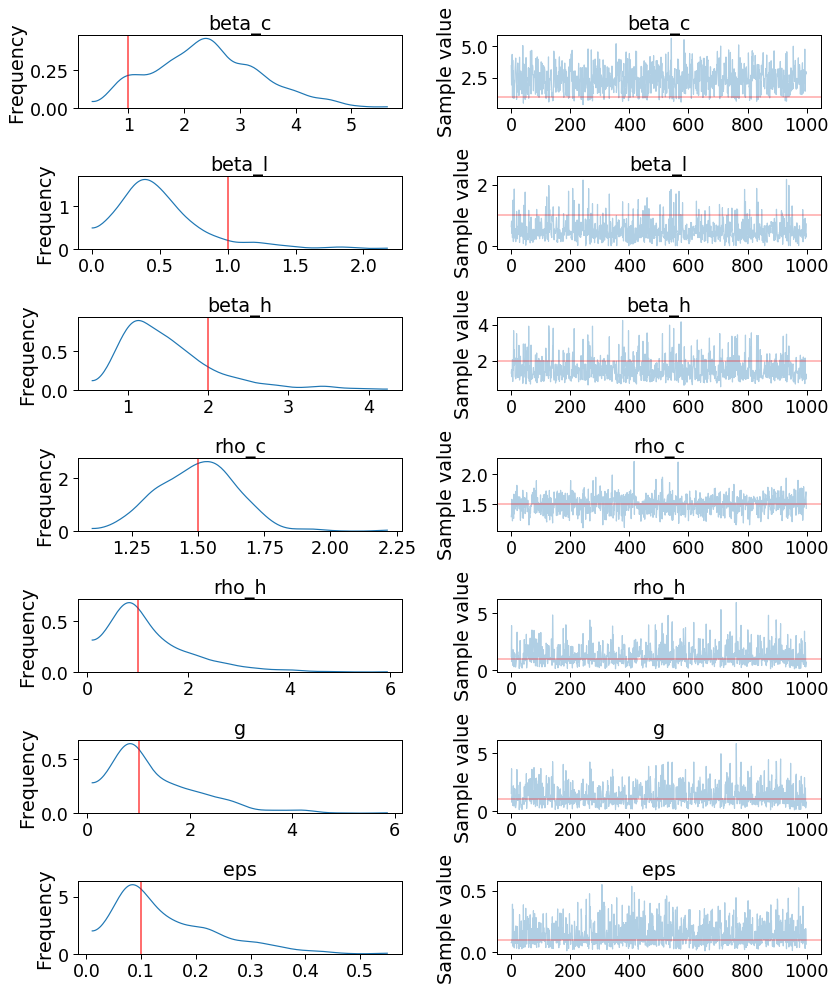

In [85]:
ndraws = 500
nburn = 500

with pm.Model() as pm_model:
    beta_c = pm.HalfNormal('beta_c', sd=2)
    beta_l = pm.HalfNormal('beta_l', sd=2)
    beta_h = pm.HalfNormal('beta_h', sd=2)
    rho_c = pm.HalfNormal('rho_c', sd=2)
    rho_h = pm.HalfNormal('rho_h', sd=2)
    g = pm.HalfNormal('g', sd=2)
    eps = pm.HalfNormal('eps', sd=2)

    theta = tt.as_tensor_variable([beta_c, beta_l, beta_h, rho_c, rho_h, g, eps])

    loglike = PymcWrapper(deepcopy(model))
#     pm.DensityDist('likelihood', lambda v: loglike(v), observed={'v': theta})
    pm.Potential('likelihood', loglike(theta))

#     trace = pm.sample(ndraws, tune=nburn, discard_tuned_samples=True, chains=2)
#     trace = pm.sample(ndraws, tune=nburn, discard_tuned_samples=False, chains=2)
    trace = pm.sample(step=SMC(), draws=1000, chains=4)

# plot the traces
_ = pm.traceplot(trace, lines={k: v for k, v in zip(model.param_l, model.t_params)})

# put the chains in an array (for later!)
df_trace = pm.trace_to_dataframe(trace)

In [78]:
# half normal
print(loglike.call_counter, loglike.logpgrad.call_counter)
print(loglike.model.call_counter, loglike.model.sub_pops[0].call_counter)

{'ll': 2, 'grad': 1, 'll_nocache': 1} {'grad': 2, 'll_grad': 0}
{'LL': 15, 'grad': 0} {'solve': 16, 'grad': 0}


In [91]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
beta_c,2.601643,1.096781,0.035137,0.821611,4.817817
beta_l,0.525248,0.296903,0.008215,0.058326,1.051052
beta_h,1.426117,0.537919,0.015775,0.623945,2.489652
rho_c,1.502203,0.174440,0.005610,1.197898,1.873568
rho_h,2.220748,0.921996,0.029128,0.645408,3.997910
g,2.282228,0.805151,0.024950,0.754732,3.816368
eps,0.127030,0.089849,0.003136,0.020743,0.304390


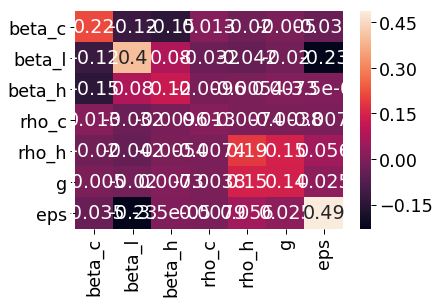

In [92]:
# Plot covariance
sns.heatmap(pd.DataFrame(pm.trace_cov(trace, model=pm_model),
                         columns=model.param_l, index=model.param_l),
            annot=True, fmt='1.2g')

# Pairplots

In [17]:
from snepits.utils.pymc3 import trace_pairplot

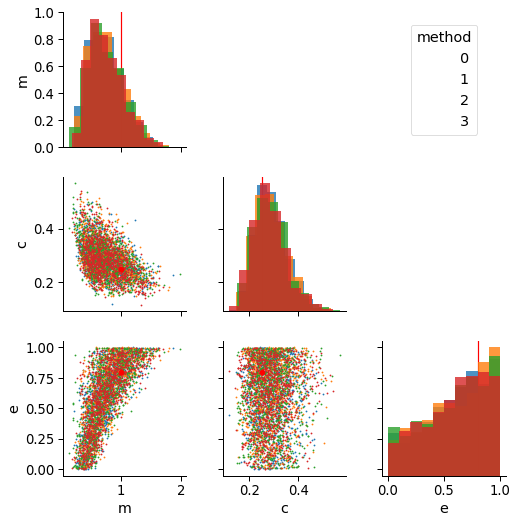

In [23]:
# Split by chain
sns.set_context("paper", font_scale=1.5)
traces = [pm.trace_to_dataframe(trace, chains=i) for i in trace.chains]
trace_pairplot(traces, diag_kind='hist', s=1, t_params=model.t_params)

/home/alex/anaconda3/envs/households/lib/python3.7/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.patches.Patch object at 0x7f0059048748> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


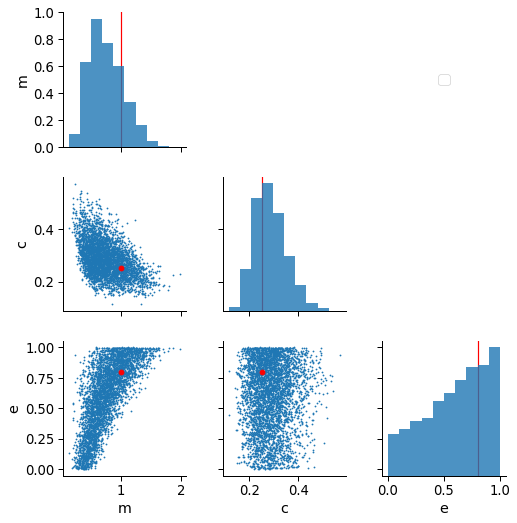

In [22]:
sns.set_context("paper", font_scale=1.5)
trace_pairplot([pd.concat(traces)], diag_kind='hist', s=1, t_params=model.t_params)